# IMPORT REQUIRED LIBRARIES

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.io
from tqdm import tqdm

import os
os.chdir("..")
os.chdir("..")
os.chdir("./src")
from WSMBSS import *
os.chdir("..")
os.chdir("NumericalExperiments/SoundSeparation")
from numba import njit
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import ortho_group

import IPython
from scipy.io import wavfile
import scipy.signal
import librosa
import pylab as pl
np.random.seed(100)
notebook_name = 'Antisparse_music_separation'

# READ TWO MUSIC SAMPLES

In [2]:
wav_loc1 = 'SoundData/LedZeppelin.wav'
rate, data1 = wavfile.read(wav_loc1)
data1 = data1[:200000,0]
data1 = data1 / np.max(np.abs(data1))
# data1 = 2*ZeroOneNormalizeData(data1)-1

wav_loc2 = 'SoundData/Whale.wav'
rate2, data2 = wavfile.read(wav_loc2)
data2 = data2[:200000,0]
data2 = data2 / np.max(np.abs(data2))
# data2 = 2*ZeroOneNormalizeData(data2)-1

wav_loc3 = 'SoundData/Paganini.wav'
rate3, data3 = wavfile.read(wav_loc3)
data3 = data3[:200000,0]
data3 = data3 / np.max(np.abs(data3))

# wav_loc4 = 'SoundData/Roadgame.wav'
# rate4, data4 = wavfile.read(wav_loc4)
# data4 = data4[:200000,0]
# data4 = data4 / 32768

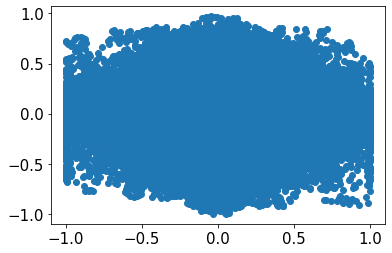

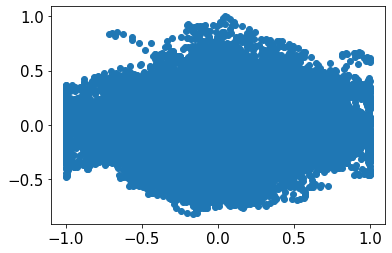

In [3]:
plt.figure()
plt.scatter(data1, data2)
plt.figure()
plt.scatter(data1, data3)

# LED ZEPPELIN - CUSTARD PIE

(200000,)

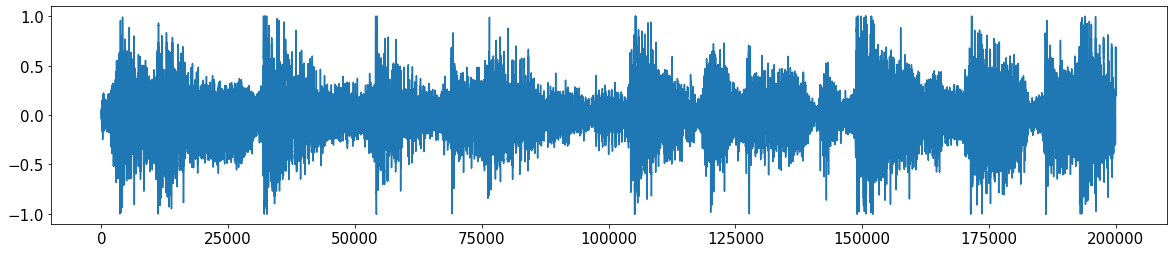

In [4]:
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(data1)
data1.shape

In [5]:
IPython.display.Audio(data=data1, rate=rate)

# YES - DON'T KILL THE WHALE

(200000,)

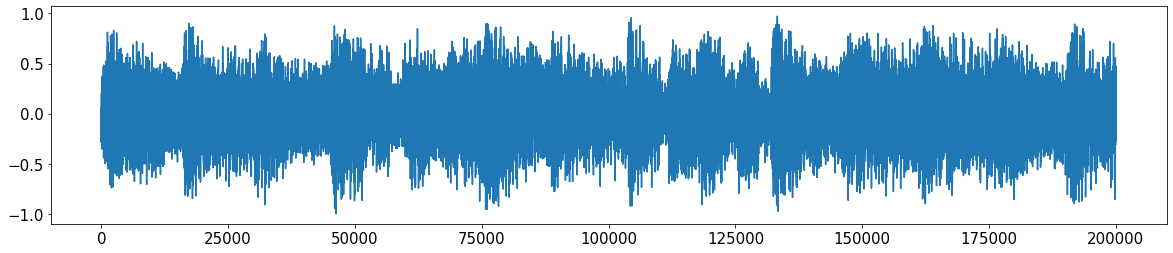

In [6]:
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(data2)
data2.shape

In [7]:
IPython.display.Audio(data=data2, rate=rate)

# GENERATE SOURCE MATRIX

In [8]:
noise = np.random.uniform(-1, 1, 200000)
S = np.zeros((3,200000))
S[0,:] = data1
S[1,:] = data2
S[2,:] = data3

# EXPERIMENTAL SETUP

In [9]:
NumberofMixtures = 3
NumberofSources = 3

# A, X = WSM_Mixing_Scenario(S, NumberofMixtures, 0.5)
A = ortho_group.rvs(NumberofMixtures)
X = A @ S

print('The following is the mixture matrix')
display_matrix(A)

The following is the mixture matrix


<IPython.core.display.Math object>

# LISTEN MIXTURE SONGS

In [10]:
IPython.display.Audio(data=(X[0,:]), rate=rate)

In [11]:
IPython.display.Audio(data=(X[1,:]), rate=rate)

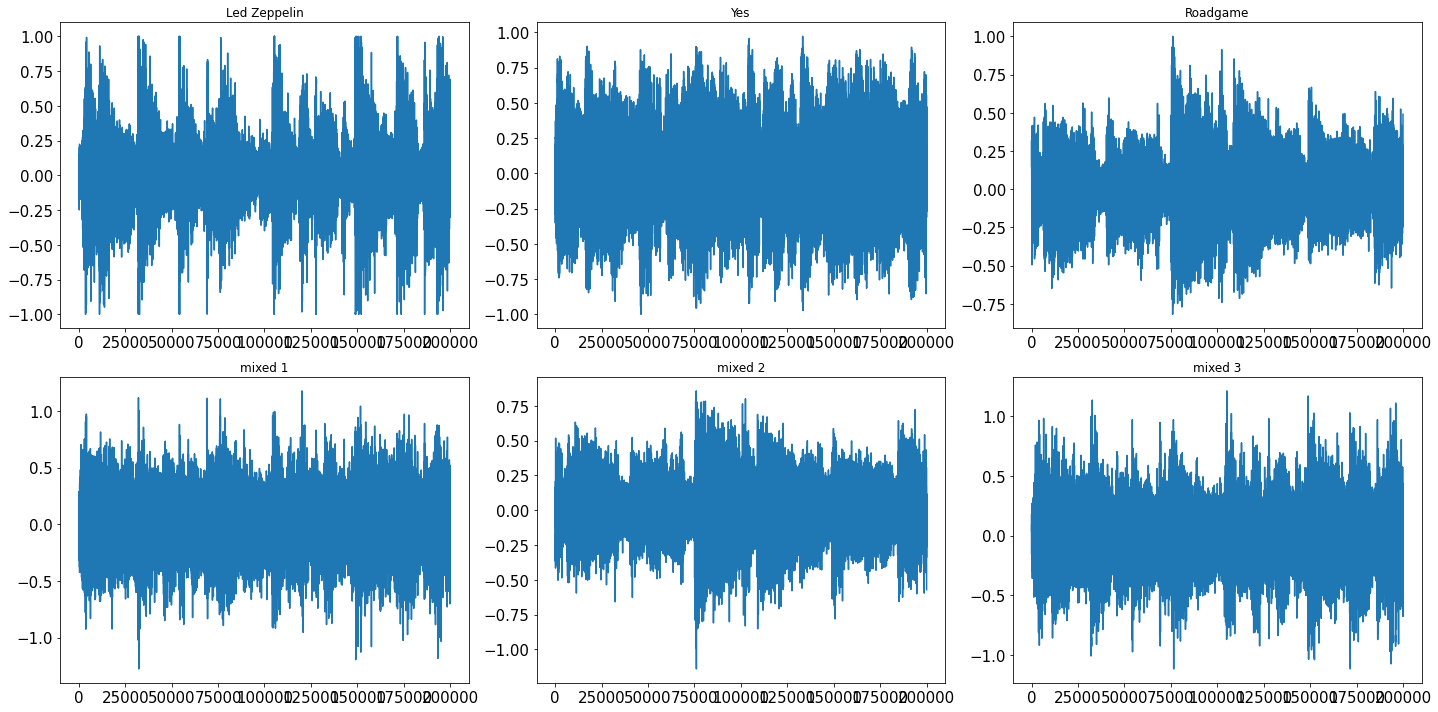

In [12]:
figure = plt.figure(figsize=(20,10))

pl.subplot(231)
pl.plot(data1)
pl.title('Led Zeppelin')
pl.subplot(232)
pl.plot(data2)
pl.title('Yes')
pl.subplot(233)
pl.plot(data3)
pl.title('Roadgame')


pl.subplot(234)
pl.plot(X[0,:])
pl.title('mixed 1')
pl.subplot(235)
pl.plot(X[1,:])
pl.title('mixed 2')
pl.subplot(236)
pl.plot(X[2,:])
pl.title('mixed 3')

plt.tight_layout()
pl.show()

# ANTI-SPARSE SOURCE SEPARATIN WITH WSM

In [19]:
MUS = 0.6
gamma_stop = 1e-3
OUTPUT_COMP_TOL = 1e-6
MAX_OUT_ITERATIONS= 3000
LayerGains = [1,1]
LayerMinimumGains = [0.2,0.2]
LayerMaximumGains = [1e6,5]
WScalings = [0.005,0.005]
GamScalings = [2,1]
zeta = 5*1e-5
beta = 0.5
muD = [1.125, 0.2]

s_dim = S.shape[0]
x_dim = X.shape[0]
h_dim = s_dim
samples = S.shape[1]
W_HX = np.eye(h_dim, x_dim)
W_YH = np.eye(s_dim, h_dim)

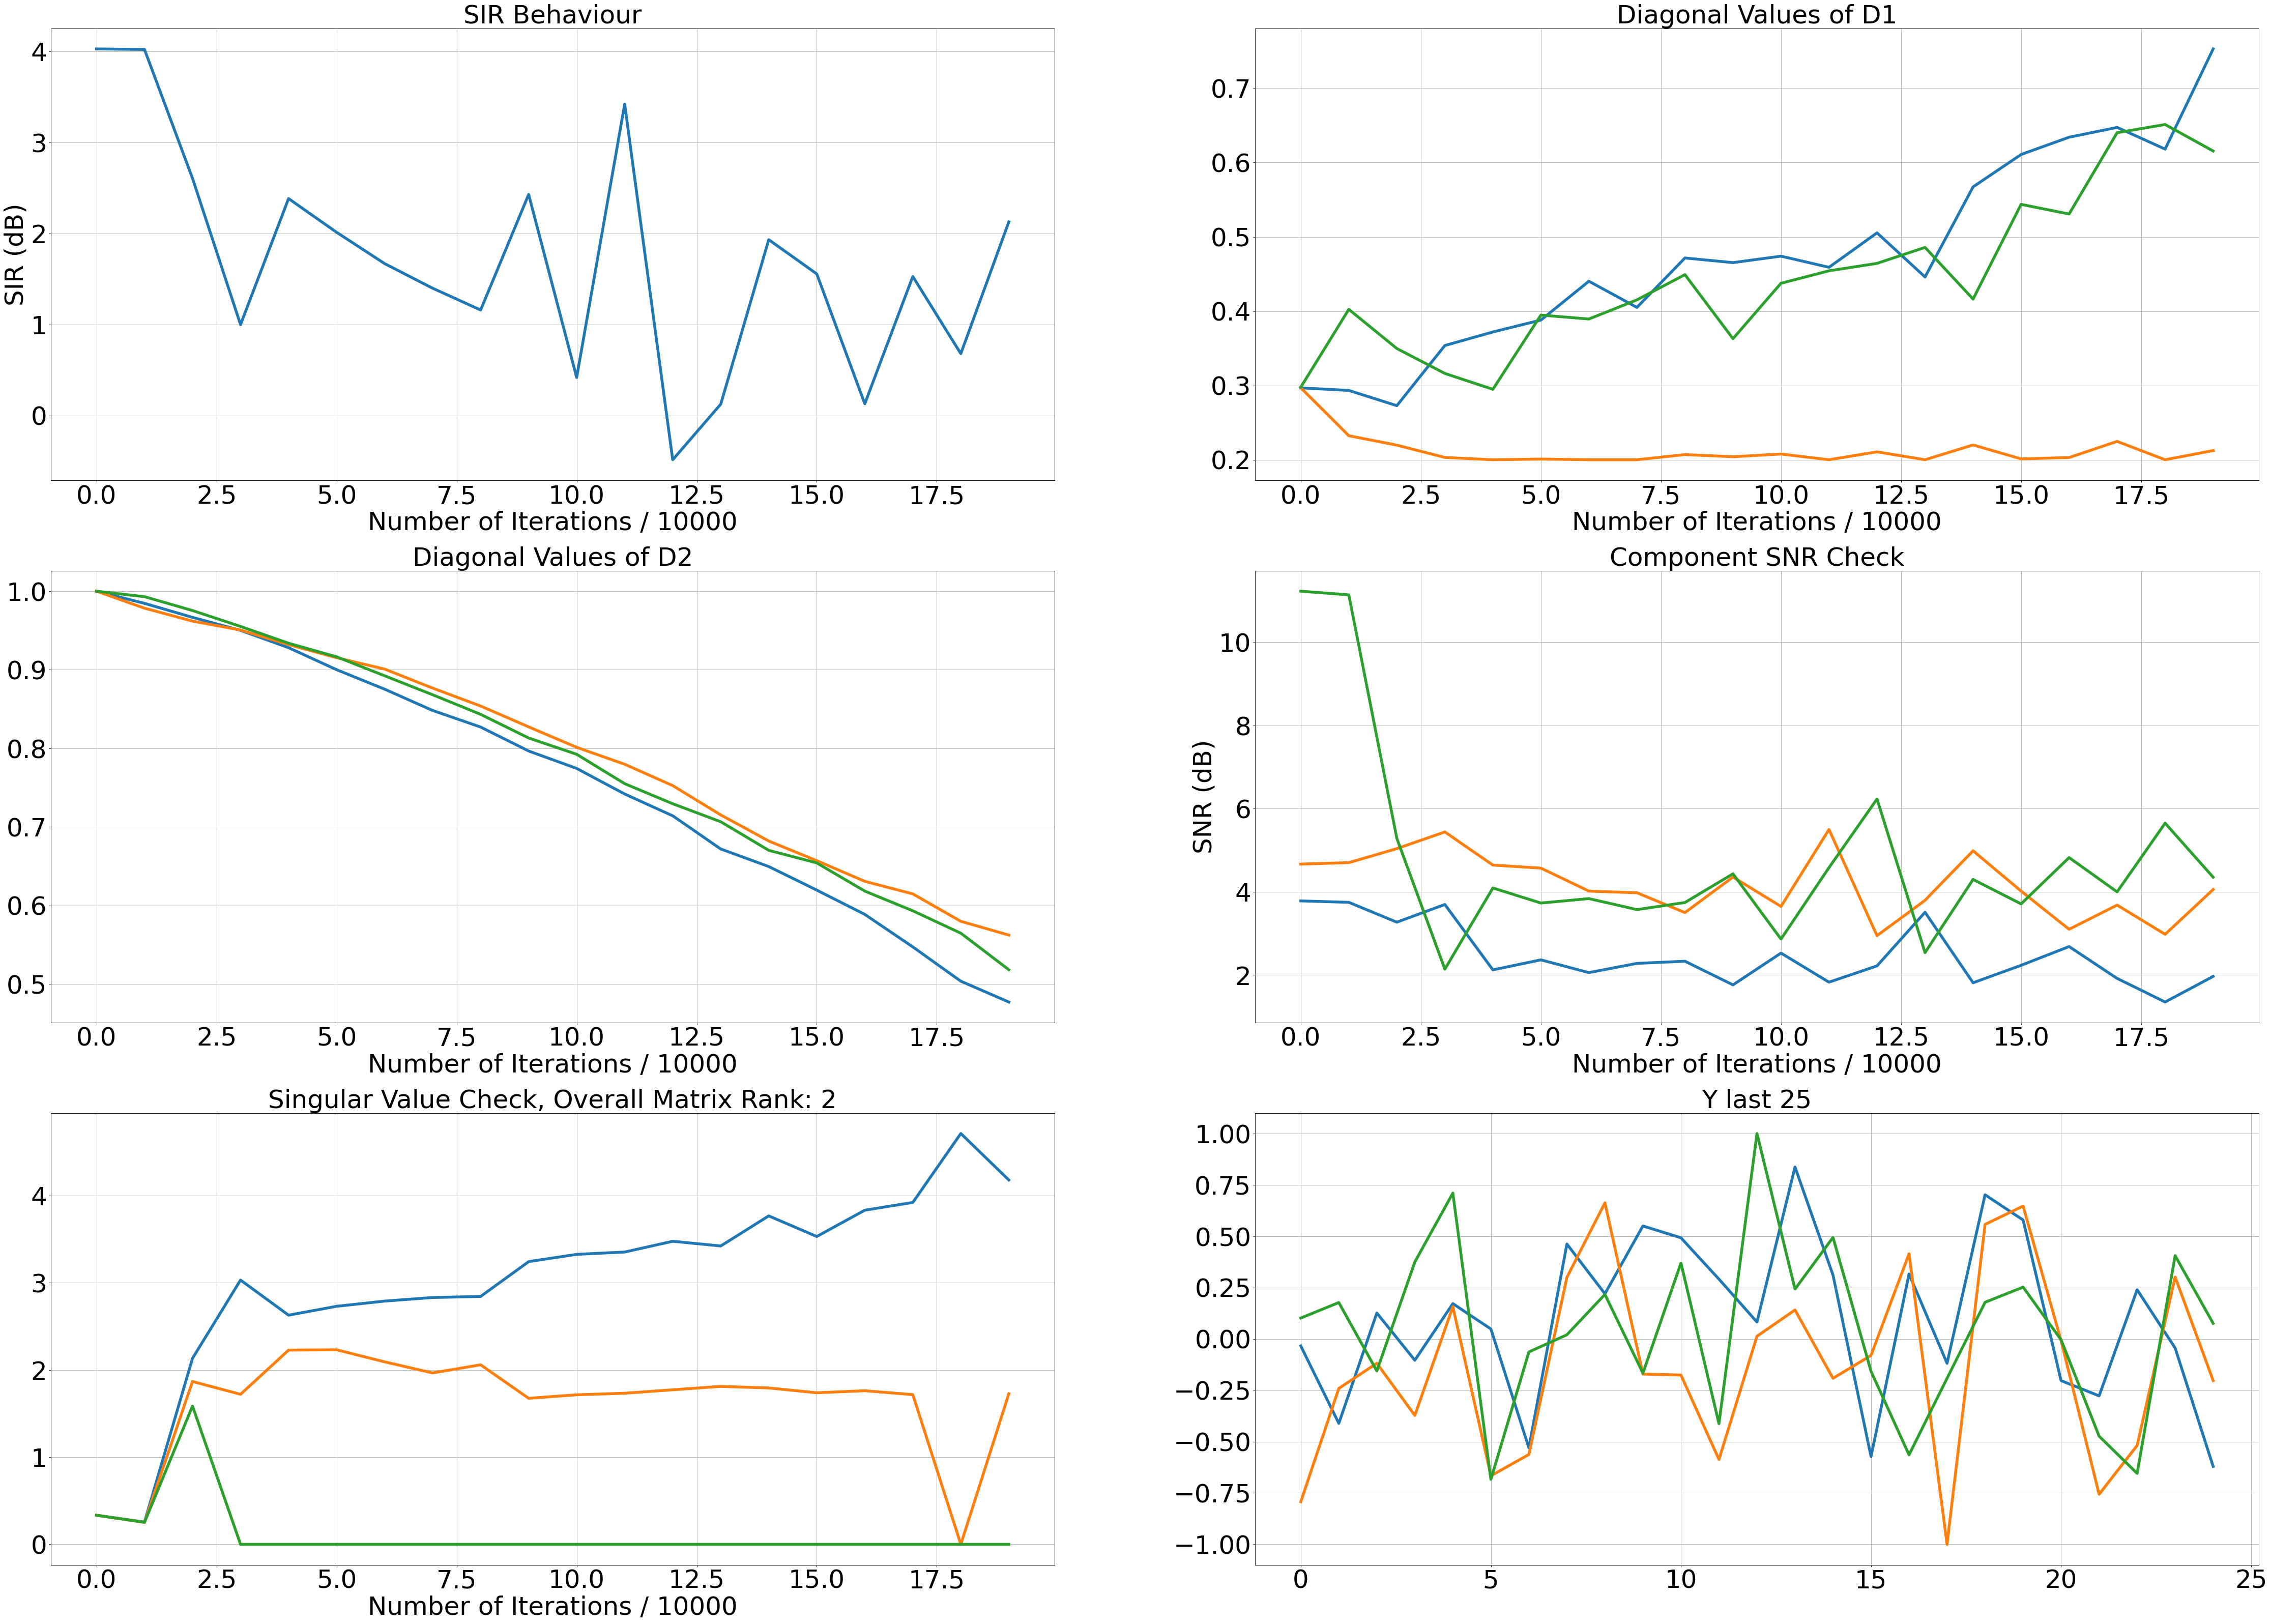

100%|██████████| 200000/200000 [23:32<00:00, 141.59it/s]


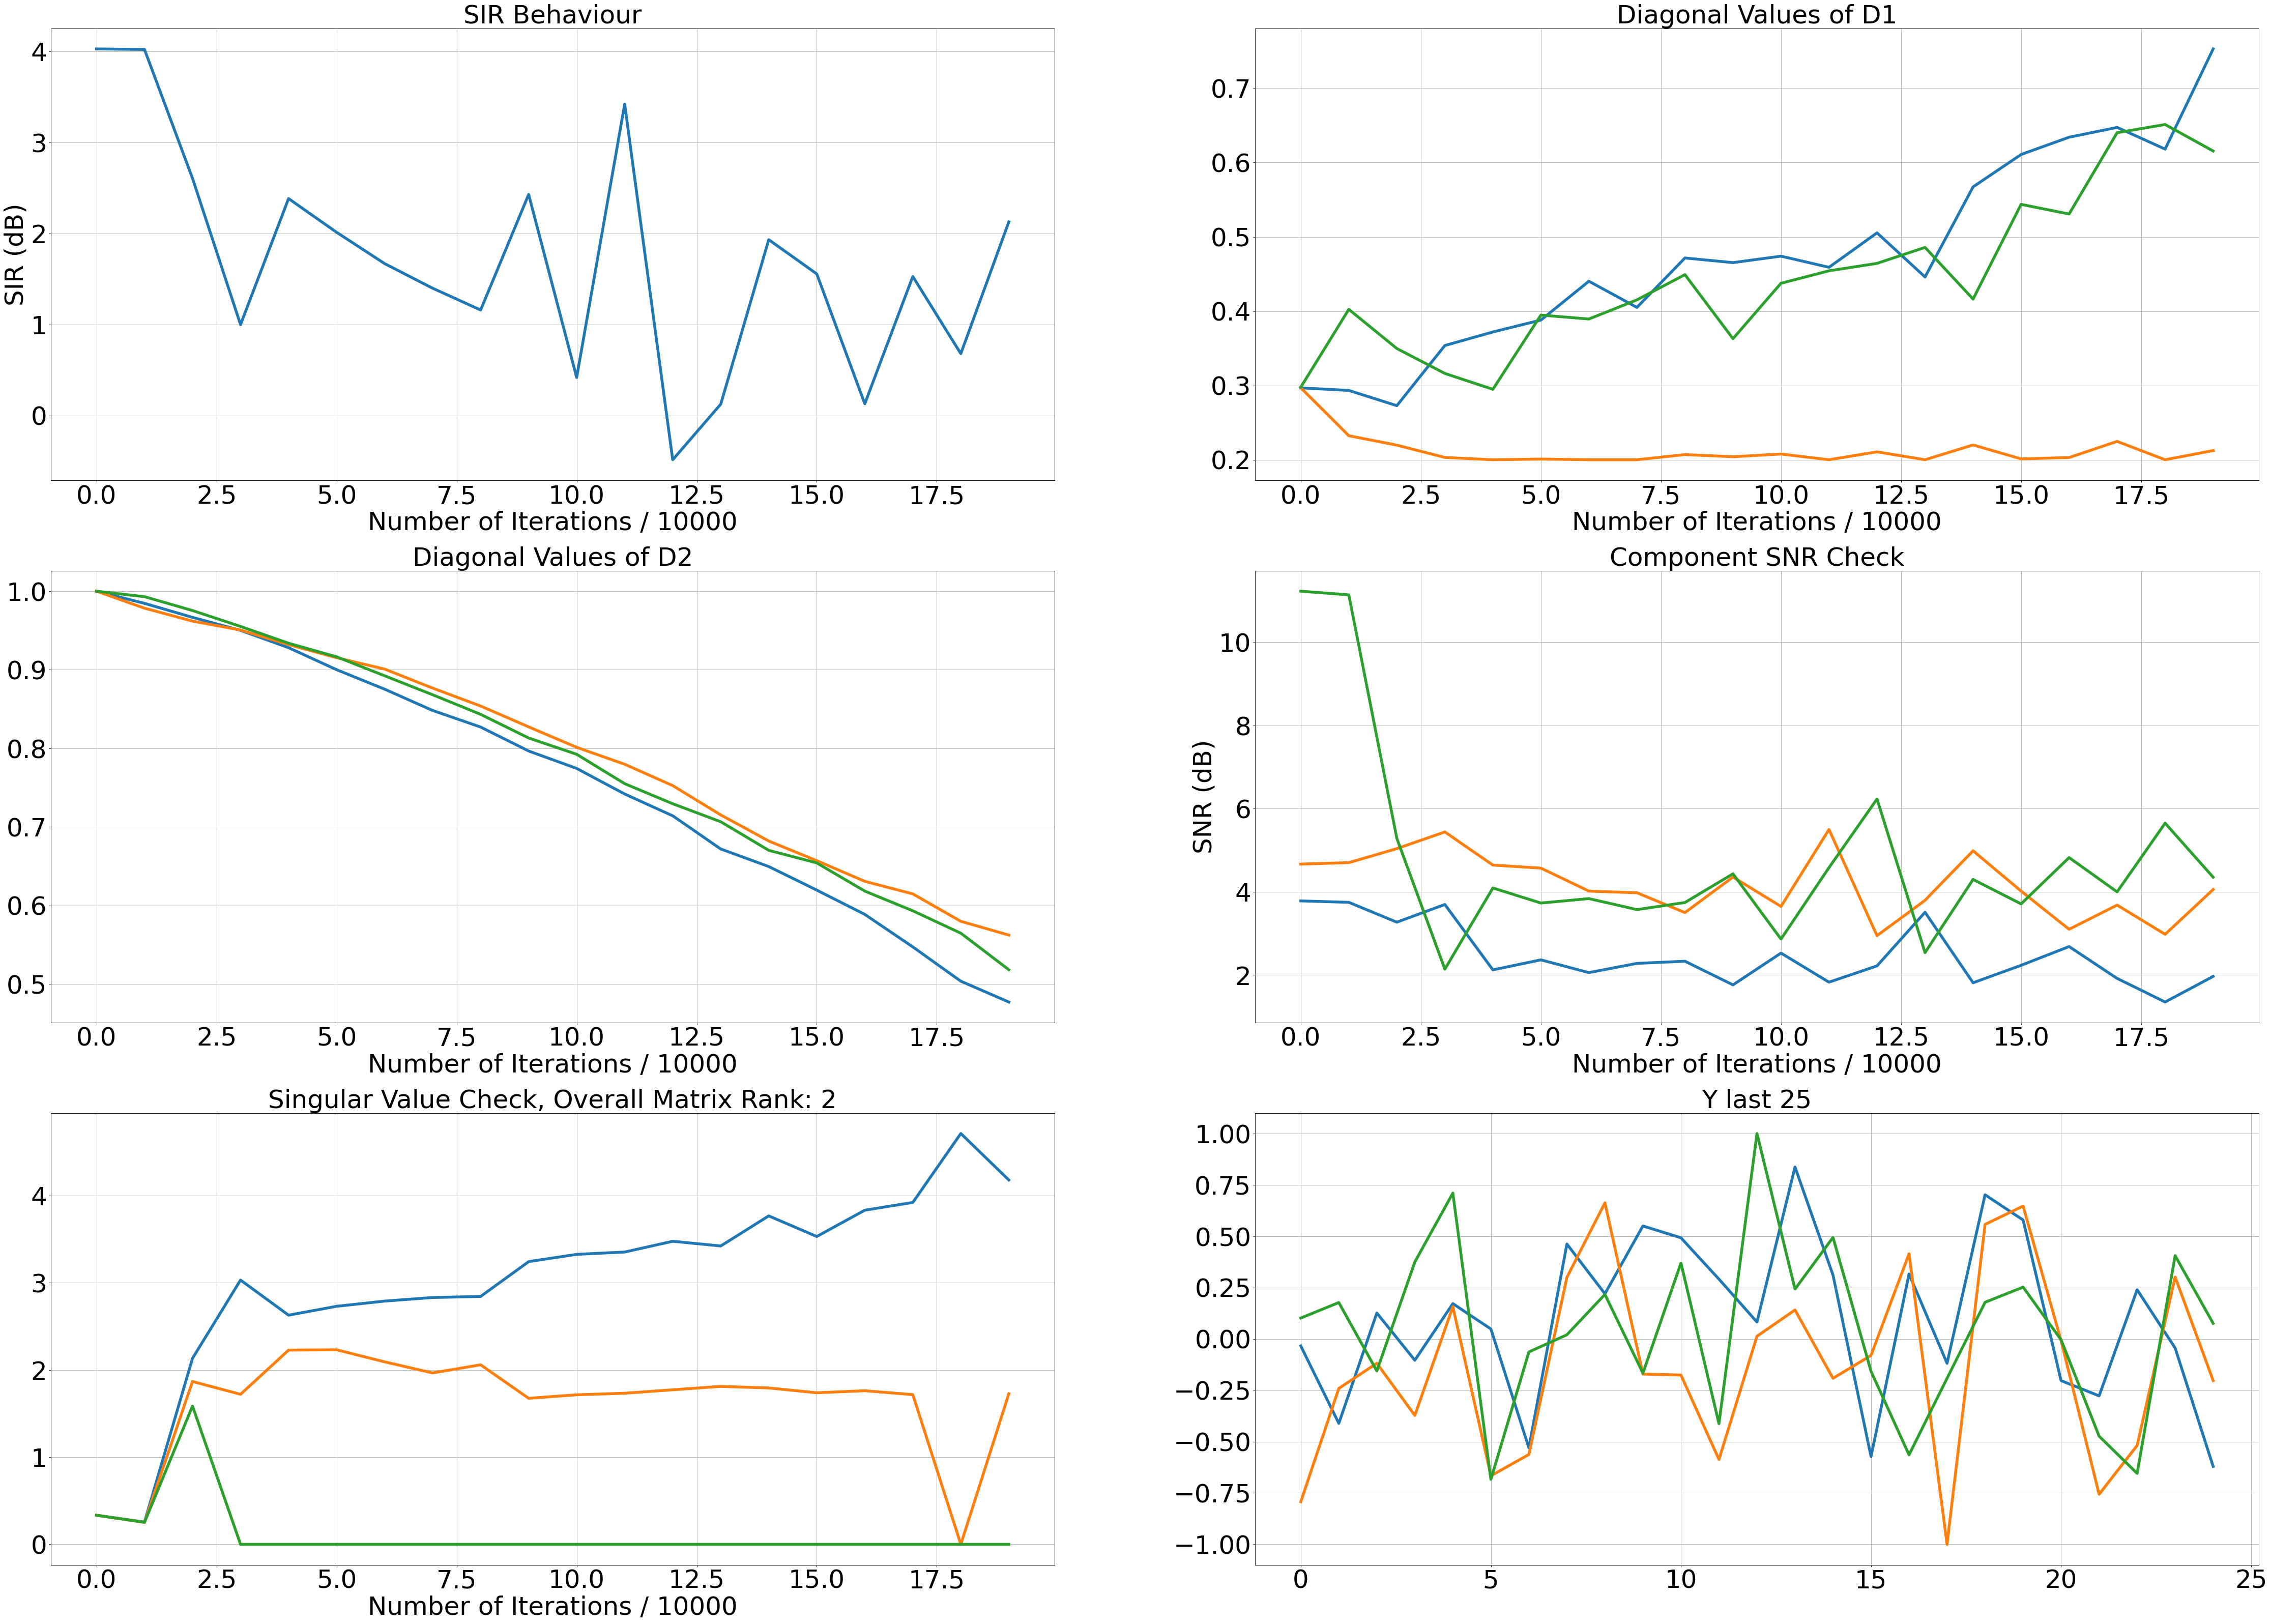

In [20]:
debug_iteration_point = 10000
modelWSM = OnlineWSMBSS(s_dim = s_dim, x_dim = x_dim, h_dim = h_dim, 
                        gamma_start = MUS, gamma_stop = gamma_stop, beta = beta, zeta = zeta, 
                        muD = muD,WScalings = WScalings, GamScalings = GamScalings,
                        W_HX = W_HX, W_YH = W_YH,
                        DScalings = LayerGains, LayerMinimumGains = LayerMinimumGains,
                        LayerMaximumGains = LayerMaximumGains,neural_OUTPUT_COMP_TOL = OUTPUT_COMP_TOL,
                        set_ground_truth = True, S = S, A = A)

modelWSM.fit_batch_antisparse(X, n_epochs = 1, 
                                neural_lr_start = 0.75,
                                neural_lr_stop = 0.05,
                                debug_iteration_point = debug_iteration_point,
                                plot_in_jupyter = True,
                                )

# PLOT SINR BEHAVIOR

ERROR! Session/line number was not unique in database. History logging moved to new session 3686


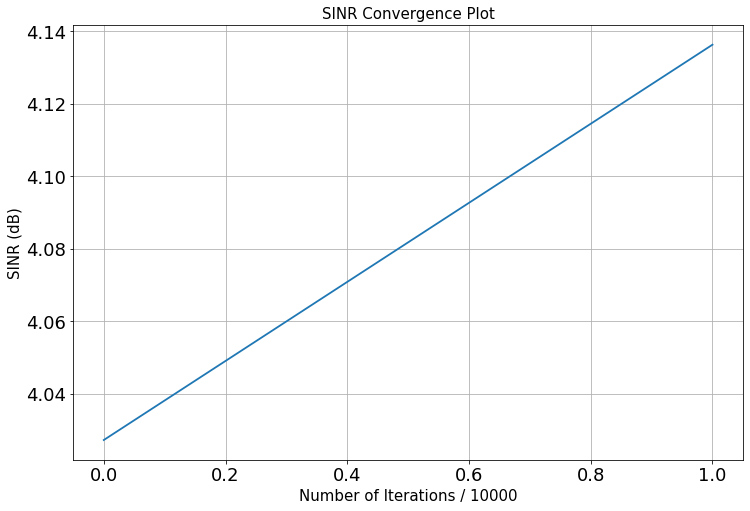

In [18]:
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
plot_convergence_plot(modelWSM.SIR_list, xlabel = 'Number of Iterations / {}'.format(debug_iteration_point),
                     ylabel = 'SINR (dB)', title = 'SINR Convergence Plot', colorcode = None, linewidth = 1.8)

# print('Final SIR: {}'.format(np.array(model.SIR_list[-1])))

# TAKE THE LEARNED SEPARATOR MATRIX FROM MODEL

In [ ]:
model = modelWSM
Szeromean = S - S.mean(axis = 1).reshape(-1,1)
Wf = model.compute_overall_mapping(return_mapping = True)
Y = Wf @ X
Yzeromean = Y - Y.mean(axis = 1).reshape(-1,1)
Y_ = signed_and_permutation_corrected_sources(Szeromean.T,Yzeromean.T)
coef_ = (Y_ * Szeromean.T).sum(axis = 0) / (Y_ * Y_).sum(axis = 0)
Y_ = coef_ * Y_
print("Component SNR Values : {}\n".format(snr(Szeromean.T, Y_)))

SINRwsm = 10*np.log10(CalculateSINR(Y_.T , Szeromean, False)[0])

print("Overall SINR : {}".format(SINRwsm))

In [ ]:
W = model.W
print('The following is the learned separator matrix')
display_matrix(W)

# SEPARATE THE MUSICS

In [ ]:
S_ = W @ X
S_.shape

# LISTEN SEPARATED MUSICS

In [ ]:
IPython.display.Audio(data=S_[0], rate=rate)

In [ ]:
IPython.display.Audio(data=S_[1], rate=rate)